Creating a new dataset based upon the wind_comparison dataset.
Plots from the dataset show there is a difference between the winds between the 
ideal dataset (nc) and the interp forcings dataset. It is therefore a need to rotate the winds.
Plots from previous notebook showing the differences in winds are under malene/ocean-ai/plot/figures.
New notebook because the files used in the previous notebook are removed and the dates are changed.

goal:
Rotate winds in the interp forcings files and make sure they then are the same as the "fasit" dataset, ie. the hindcast nc files. 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib as mpl
import numpy as np
import scipy as sp

In [2]:
#based on the 1th of May 2023

ideal_file_path = f'/lustre/storeB/project/fou/hi/roms_hindcast/norkyst_v3/sdepth'
interp_file_path = f'/lustre/storeB/project/fou/hi/foccus/datasets/norkystv3_hindcast_atm_forcing/interpolated'

ds_ideal_2023 = xr.open_dataset(f'{ideal_file_path}/2023/05/norkyst800-20230501.nc').isel(time = 0, s_rho = -1)
interp_2023_u = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Uwind.nc').isel(time=0)
interp_2023_v = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Vwind.nc').isel(time=0)
ds_ideal_2023.attrs

{'id': '3d202236-e037-41fd-acef-83840ca1b8de',
 'naming_authority': 'no.met',
 'operational_status': 'scientific',
 'iso_topic_category': 'oceans',
 'activity_type': 'Numerical Simulation',
 'keywords_vocabulary': 'GCMDSK:GCMD Science Keywords:https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords, GEMET:INSPIRE Themes:http://inspire.ec.europa.eu/theme, NORTHEMES:GeoNorge Themes:https://register.geonorge.no/metadata-kodelister/nasjonal-temainndeling',
 'keywords': 'GCMDSK:EARTH SCIENCE SERVICES > MODELS > OCEAN GENERAL CIRCULATIONMODELS (OGCM)/REGIONAL OCEAN MODELS, GCMDSK:Earth Science > Oceans > Ocean Temperature  > WATER TEMPERATURE, GCMDSK:Earth Science > Oceans > Salinity/Density > SALINITY, GCMDSK:Earth Science > Oceans > Ocean Circulation > OCEAN CURRENTS, GCMDSK:Earth Science > Oceans > Sea Ice > SEA ICE CONCENTRATION, GEMET:Oceanographic geographical features, NORTHEMES:Vær og klima, NORTHEMES:Kyst og fiskeri',
 'spatial_representation': 'grid',
 'geospati

In [15]:
interp_2023_u.head()

<xarray.Dataset> Size: 700B
Dimensions:           (Y: 5, X: 5)
Coordinates:
    time              datetime64[ns] 8B 2023-05-01
  * X                 (X) float64 40B 0.0 800.0 1.6e+03 2.4e+03 3.2e+03
  * Y                 (Y) float64 40B 0.0 800.0 1.6e+03 2.4e+03 3.2e+03
    s_rho             float64 8B ...
Data variables:
    lon               (Y, X) float64 200B ...
    lat               (Y, X) float64 200B ...
    Uwind             (Y, X) float64 200B ...
    projection_stere  int32 4B ...

In [3]:
#select out u and v winds from the ideal dataset (fasit)
ds_ideal_u_2023 = ds_ideal_2023["Uwind_eastward"]
ds_ideal_v_2023 = ds_ideal_2023["Vwind_northward"]

In [17]:
#then we have to rotate the winds for the interp forcings files
def rotate_vectorfield(U,V,alpha):
    '''rotate wind vectors clockwise. alpha may be a scalar or an array
    alpha is in degrees
    returns u,v '''
    alpha = np.array(alpha)*np.pi/180
    alpha = alpha.flatten()
    R = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)] ])
    shpe = U.shape
    origwind = np.array((U.flatten(), V.flatten()))
    if len(R.shape)==2:
        rotwind = dot(R, origwind) # for constant rotation angle
    else:
        # for rotation angle given as array with same dimensions as U and V:
        # k-loop with rotwind(k) = dot(R(i,j,k), origwind(j,k)) (einstein summation indices)
        rotwind = np.einsum("ijk,ik -> jk", R, origwind)  # einstein summation indices
    Urot, Vrot = rotwind[0,:], rotwind[1,:]
    Urot = Urot.reshape(shpe)
    Vrot = Vrot.reshape(shpe)
    return Urot, Vrot

In [18]:
urot, vrot = rotate_vectorfield(interp_2023_u["Uwind"].values, interp_2023_v["Vwind"].values, interp_2023_u["lat"].values)

In [19]:
urot

array([[ -1.131288  ,  -1.10524121,  -1.0766937 , ...,   2.73381579,
          2.75434168,   2.7741827 ],
       [ -1.08870568,  -1.06451003,  -1.04033569, ...,   2.71394275,
          2.73364317,   2.75210731],
       [ -1.04575076,  -1.02003275,  -0.99433681, ...,   2.70213092,
          2.71376315,   2.74145251],
       ...,
       [  3.35361535,   3.27951186,   3.20536104, ..., -13.33944796,
        -13.32419937, -13.32096188],
       [  3.30572382,   3.23159445,   3.15743432, ..., -13.35937088,
        -13.34410804, -13.32886521],
       [  3.25783938,   3.18368342,   3.10949668, ..., -13.37929525,
        -13.36403137, -13.34878396]], shape=(1148, 2747))

In [20]:
vrot

array([[ 2.30787882,  2.22792771,  2.14096167, ...,  9.25473093,
         9.20591919,  9.17279679],
       [ 2.23347389,  2.15863485,  2.08379772, ...,  9.27007528,
         9.21431886,  9.16408371],
       [ 2.15960592,  2.08686657,  2.01412713, ...,  9.2780046 ,
         9.22967527,  9.15966964],
       ...,
       [-0.28128491, -0.41765431, -0.55403329, ...,  6.91567269,
         6.92488681,  6.92762402],
       [-0.36931021, -0.5056915 , -0.64205194, ...,  6.90571993,
         6.91494315,  6.92415131],
       [-0.45730865, -0.59370316, -0.73007682, ...,  6.8957702 ,
         6.90499541,  6.91420746]], shape=(1148, 2747))

Text(0.5, 1.0, 'After rotation')

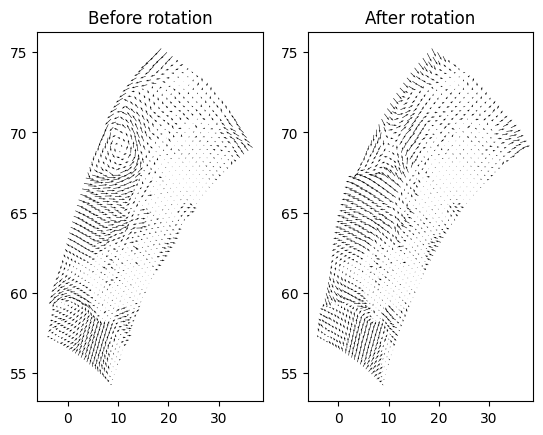

In [127]:
s  = 50
fig, ax = plt.subplots(1,2)
ax[0].quiver(interp_2023_u["lon"].values[::s,::s], interp_2023_u["lat"].values[::s,::s], interp_2023_u["Uwind"].values[::s,::s], interp_2023_v["Vwind"].values[::s,::s])
ax[1].quiver(interp_2023_u["lon"].values[::s,::s], interp_2023_u["lat"].values[::s,::s],urot[::s,::s], vrot[::s,::s])
ax[0].set_title("Before rotation")
ax[1].set_title("After rotation")

/tmp/ipykernel_999602/208363796.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("turbo")


Text(0.5, 1.0, 'After rotation - v')

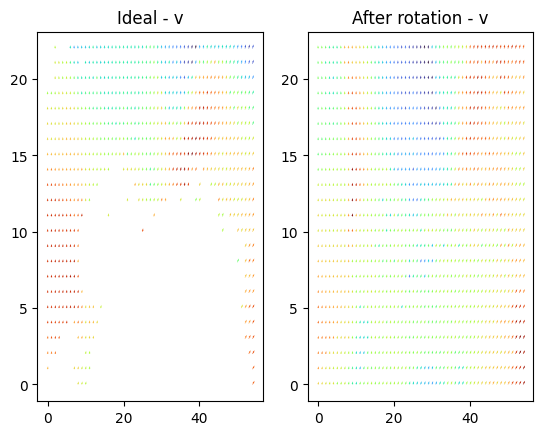

In [31]:
s  = 50
fig, ax = plt.subplots(1,2)
cmap = mpl.cm.get_cmap("turbo")
ax[0].quiver(ds_ideal_u_2023["lon"].values[::s,::s], ds_ideal_u_2023["lat"].values[::s,::s], ds_ideal_v_2023.values[::s,::s], cmap = cmap)
ax[1].quiver(interp_2023_u["lon"].values[::s,::s], interp_2023_u["lat"].values[::s,::s],vrot[::s,::s], cmap = cmap)
ax[0].set_title("Ideal - v")
ax[1].set_title("After rotation - v")

/tmp/ipykernel_999602/3071960163.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("turbo")


Text(0.5, 1.0, 'After rotation - u')

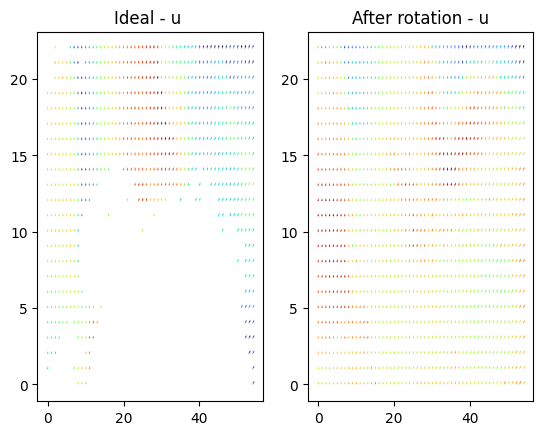

In [ ]:
s  = 50
fig, ax = plt.subplots(1,2)
cmap = mpl.cm.get_cmap("turbo")
ax[0].quiver(ds_ideal_u_2023["lon"].values[::s,::s], ds_ideal_u_2023["lat"].values[::s,::s], ds_ideal_u_2023.values[::s,::s], cmap = cmap)
ax[1].quiver(interp_2023_u["lon"].values[::s,::s], interp_2023_u["lat"].values[::s,::s],urot[::s,::s], cmap = cmap)
ax[0].set_title("Ideal - u ")
ax[1].set_title("After rotation - u")

In [ ]:
def plotting_output_compare(variable_1, variable_2, title_1, title_2, title_3, variable_1_name, variable_2_name, suptitle, **kwargs):
    fig,ax = plt.subplots(3, figsize = (8,14))

    #Colormap colors
    cmap = plt.cm.GnBu
    norm1 = mpl.colors.Normalize(vmin=-15,vmax=20) 
    #norm2 = mpl.colors.Normalize(vmin=-10,vmax=10) #small values in the last plot to be able to easily spot the difference when comparing plots 

    #Image 1
    image1 = ax[0].pcolormesh(variable_1, shading = "auto", cmap=cmap, norm = norm1) #, norm = norm1)
    ax[0].set_title(title_1)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    #Image 2
    image2 = ax[1].pcolormesh(variable_2, shading = "auto", cmap = cmap, norm = norm1)#, norm = norm1)
    ax[1].set_title(title_2)
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("y")

    #Image 3 - comparing the data. Value 2 - value 1. 
    image3 = ax[2].pcolormesh(variable_2 - variable_1, **kwargs)#, norm = norm2)
    #image3 = ax[2].quiver(x,y,variable_2 - variable_1, scale=1, color = "black")
    ax[2].set_title(title_3)
    ax[2].set_xlabel("x")
    ax[2].set_ylabel("y")
    plt.suptitle(suptitle)
    plt.tight_layout()

    
    fig.colorbar(image1, cmap=cmap, ax=ax[0], label = f'{variable_1_name}')
    fig.colorbar(image2, cmap=cmap, ax=ax[1], label = f'{variable_2_name}')
    fig.colorbar(image3, cmap=cmap, ax=ax[2], label = f'Comparison of: {variable_2_name} - {variable_1_name}')
    return plotting_output_compare

Text(0.5, 1.0, 'Truth - interp forcings. Uwind - non rotated')

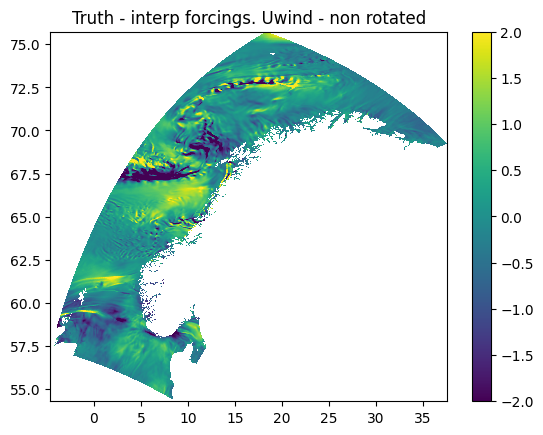

In [11]:
plt.pcolormesh(ds_ideal_u_2023.lon, ds_ideal_u_2023.lat, (ds_ideal_u_2023.values - interp_2023_u["Uwind"]), vmin=-2, vmax=2)
plt.colorbar()
plt.title(f'Truth - interp forcings. Uwind - non rotated')
#lag for v og send til Matheusz 

Text(0.5, 1.0, 'Truth - interp forcings. Uwind - non rotated')

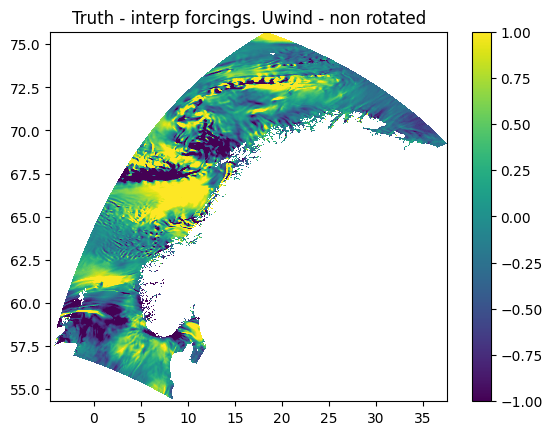

In [10]:
plt.pcolormesh(ds_ideal_u_2023.lon, ds_ideal_u_2023.lat, (ds_ideal_u_2023.values - interp_2023_u["Uwind"]), vmin=-1, vmax=1)
plt.colorbar()
plt.title(f'Truth - interp forcings. Uwind - non rotated')

Text(0.5, 1.0, 'Truth - interp forcings. Vwind - non rotated')

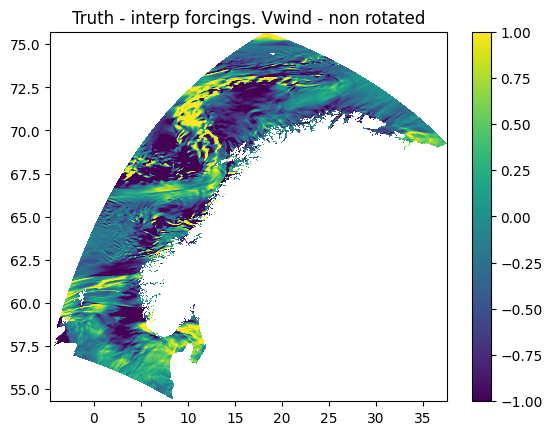

In [13]:
plt.pcolormesh(ds_ideal_v_2023.lon, ds_ideal_v_2023.lat, (ds_ideal_v_2023.values - interp_2023_v["Vwind"]), vmin=-1, vmax=1)
plt.colorbar()
plt.title(f'Truth - interp forcings. Vwind - non rotated')

Text(0.5, 1.0, 'Truth - interp forcings. Vwind - non rotated')

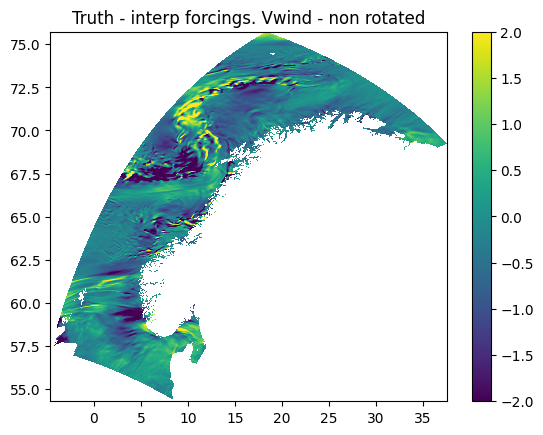

In [14]:
plt.pcolormesh(ds_ideal_v_2023.lon, ds_ideal_v_2023.lat, (ds_ideal_v_2023.values - interp_2023_v["Vwind"]), vmin=-2, vmax=2)
plt.colorbar()
plt.title(f'Truth - interp forcings. Vwind - non rotated')

/tmp/ipykernel_999602/3726884462.py:22: UserWarning: The following kwargs were not used by contour: 'shading'
  image3 = ax[2].contourf(variable_2 - variable_1, shading = "auto")#, norm = norm2)


<function __main__.plotting_output_compare(variable_1, variable_2, title_1, title_2, title_3, variable_1_name, variable_2_name, suptitle)>

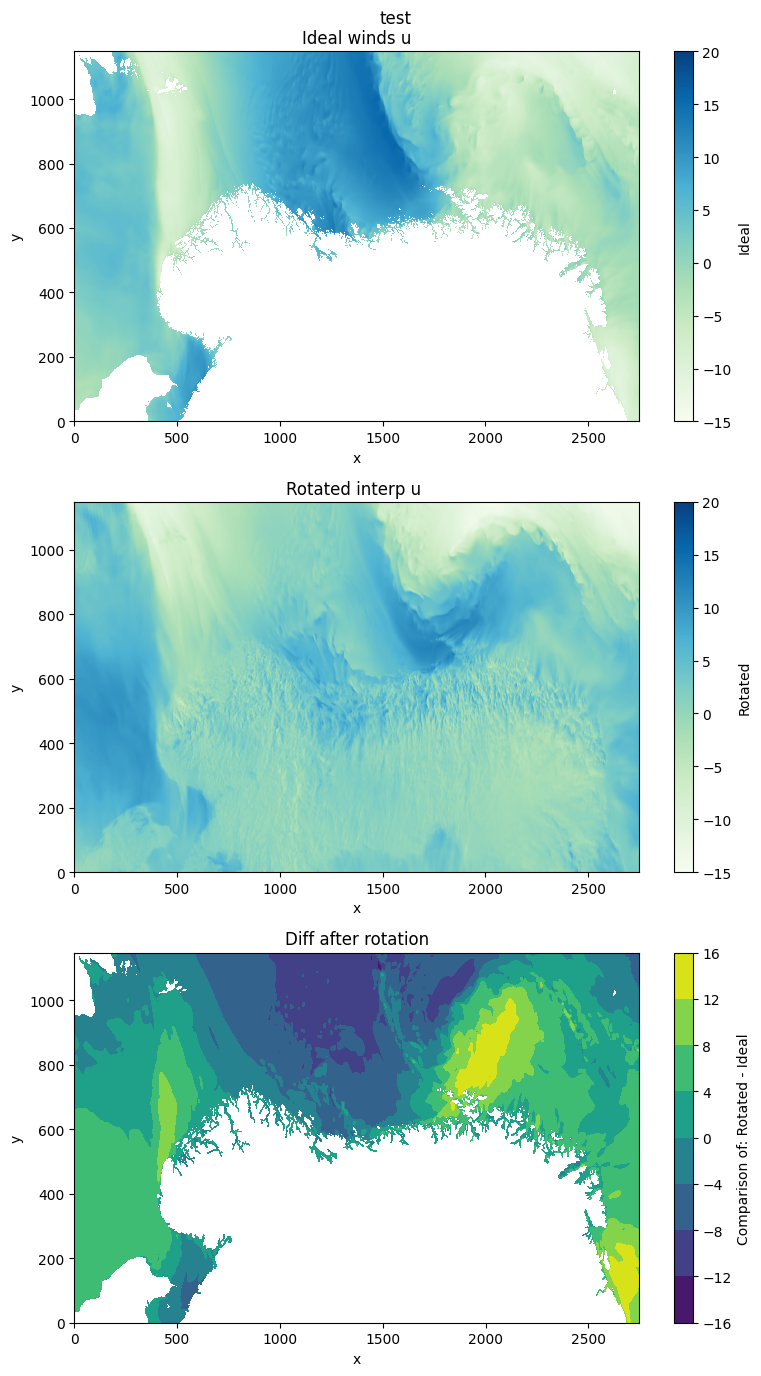

In [56]:
plotting_output_compare(variable_1=ds_ideal_u_2023, variable_2=urot, title_1="Ideal winds u", title_2="Rotated interp u ", title_3="Diff after rotation", suptitle="test", variable_1_name="Ideal", variable_2_name="Rotated")

/tmp/ipykernel_1004080/1259481349.py:22: UserWarning: The following kwargs were not used by contour: 'shading'
  image3 = ax[2].contourf(variable_2 - variable_1, shading = "auto", **kwargs)#, norm = norm2)


<function __main__.plotting_output_compare(variable_1, variable_2, title_1, title_2, title_3, variable_1_name, variable_2_name, suptitle, **kwargs)>

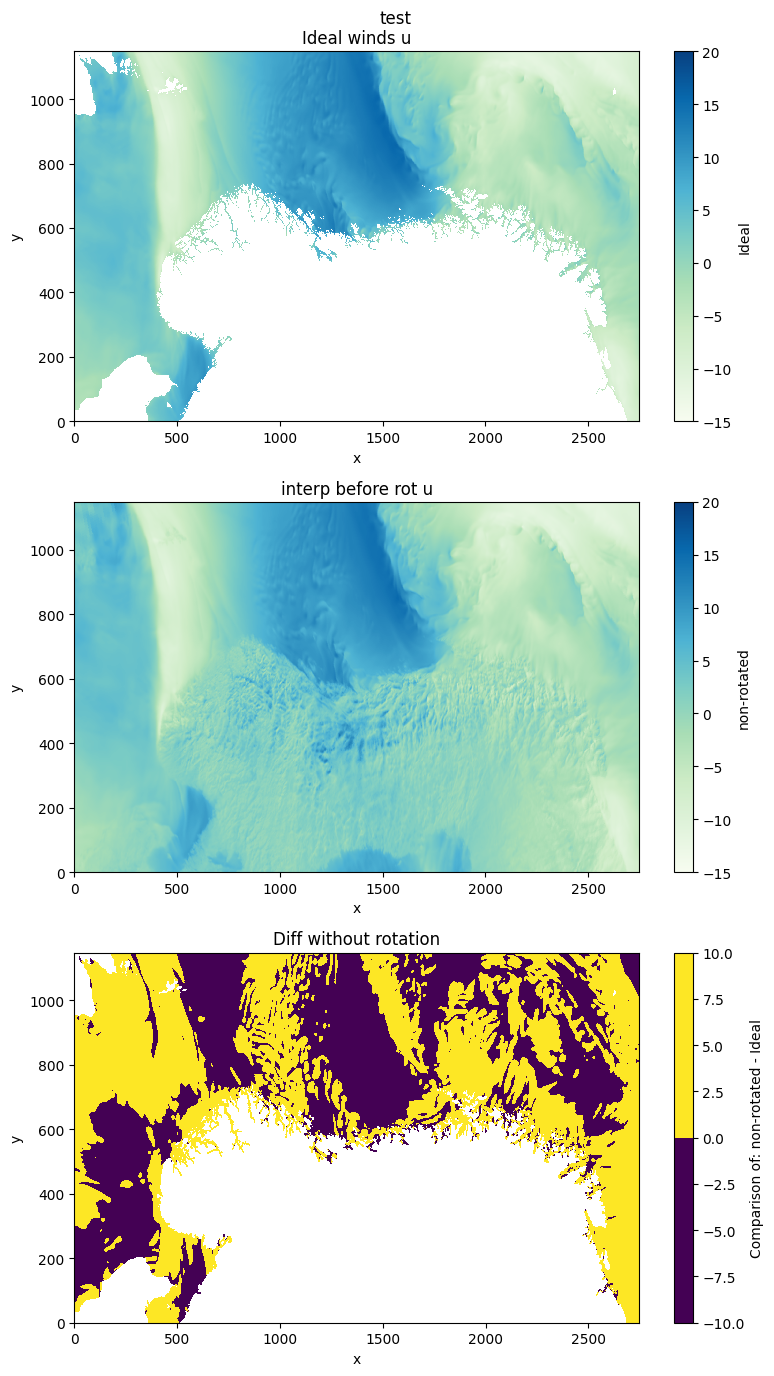

In [6]:

plotting_output_compare(variable_1=ds_ideal_u_2023, variable_2=interp_2023_u["Uwind"], title_1="Ideal winds u", title_2="interp before rot u", title_3="Diff without rotation", suptitle="test", variable_1_name="Ideal", variable_2_name="non-rotated", vmin=-1, vmax=1)

In [38]:
diff = ds_ideal_u_2023.values - interp_2023_u["Uwind"].values
np.printoptions(np.inf)
print(diff)

[[        nan         nan         nan ... -0.23543937 -0.20795071
  -0.22554809]
 [        nan         nan         nan ... -0.21340899 -0.24212279
  -0.2252354 ]
 [        nan         nan         nan ... -0.23117195 -0.24008267
  -0.26495243]
 ...
 [        nan         nan         nan ...  1.51530182  1.52930522
   1.55000019]
 [        nan         nan         nan ...  1.5096565   1.52366387
   1.54766648]
 [        nan         nan         nan ...  1.50401135  1.51801904
   1.54202295]]


In [39]:
diff2 = ds_ideal_u_2023.values - urot

In [40]:
print(diff2)

[[         nan          nan          nan ... -10.65381539 -10.59434135
  -10.5941824 ]
 [         nan          nan          nan ... -10.63394235 -10.62364304
  -10.57210701]
 [         nan          nan          nan ... -10.65213073 -10.623763
  -10.60145216]
 ...
 [         nan          nan          nan ...   4.85944842   4.8541991
    4.87096207]
 [         nan          nan          nan ...   4.87937134   4.87410777
    4.8788654 ]
 [         nan          nan          nan ...   4.89929571   4.8940311
    4.89878415]]


In [41]:
#make sure it uses the same times
ds_ideal_u_2023.time.values

np.datetime64('2023-05-01T00:00:00.000000000')

In [42]:
interp_2023_u.time.values

np.datetime64('2023-05-01T00:00:00.000000000')

/tmp/ipykernel_999602/3726884462.py:22: UserWarning: The following kwargs were not used by contour: 'shading'
  image3 = ax[2].contourf(variable_2 - variable_1, shading = "auto")#, norm = norm2)


<function __main__.plotting_output_compare(variable_1, variable_2, title_1, title_2, title_3, variable_1_name, variable_2_name, suptitle)>

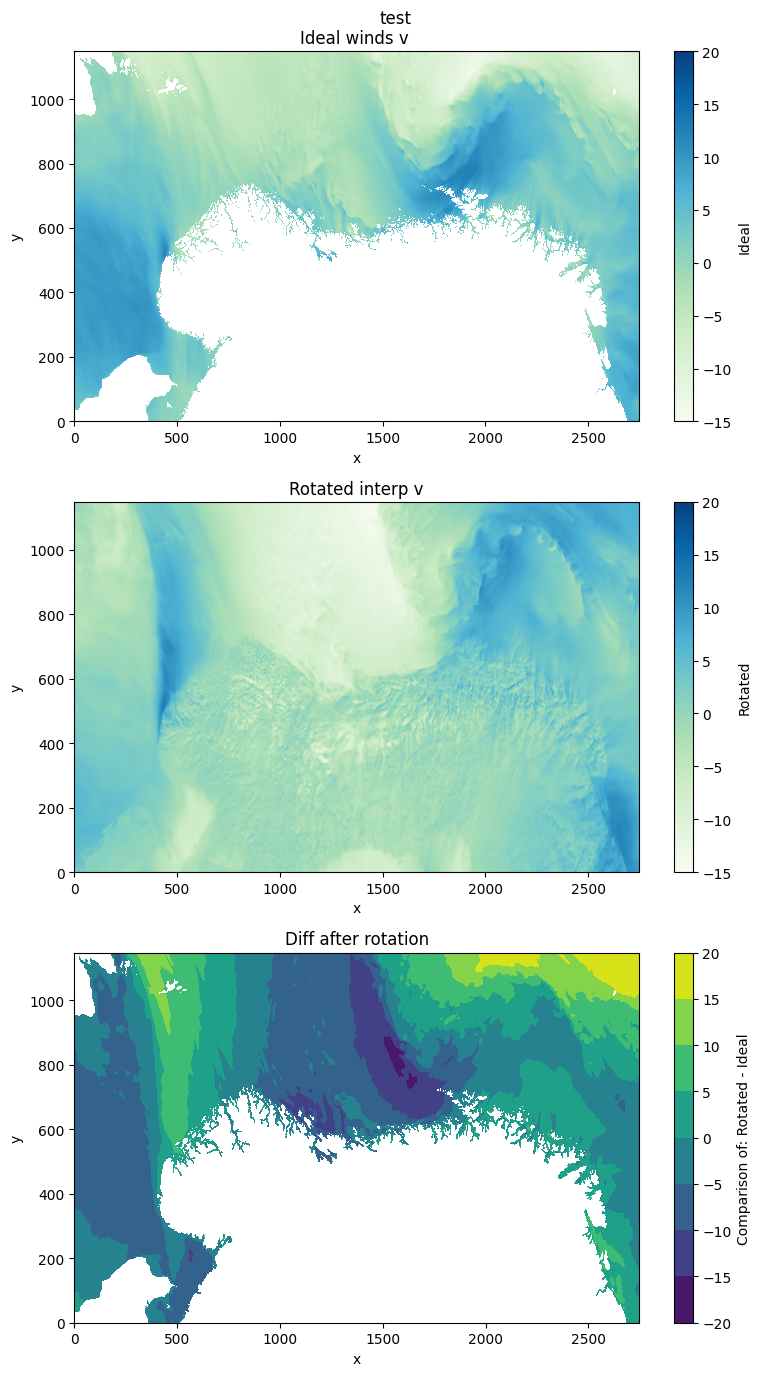

In [58]:
plotting_output_compare(variable_1=ds_ideal_v_2023, variable_2=vrot, title_1="Ideal winds v ", title_2="Rotated interp v", title_3="Diff after rotation", suptitle="test", variable_1_name="Ideal", variable_2_name="Rotated")


/tmp/ipykernel_999602/1472014548.py:22: UserWarning: The following kwargs were not used by contour: 'shading'
  image3 = ax[2].contourf(variable_2 - variable_1, shading = "auto", cmap = cmap)#, norm = norm2)


<function __main__.plotting_output_compare(variable_1, variable_2, title_1, title_2, title_3, variable_1_name, variable_2_name, suptitle)>

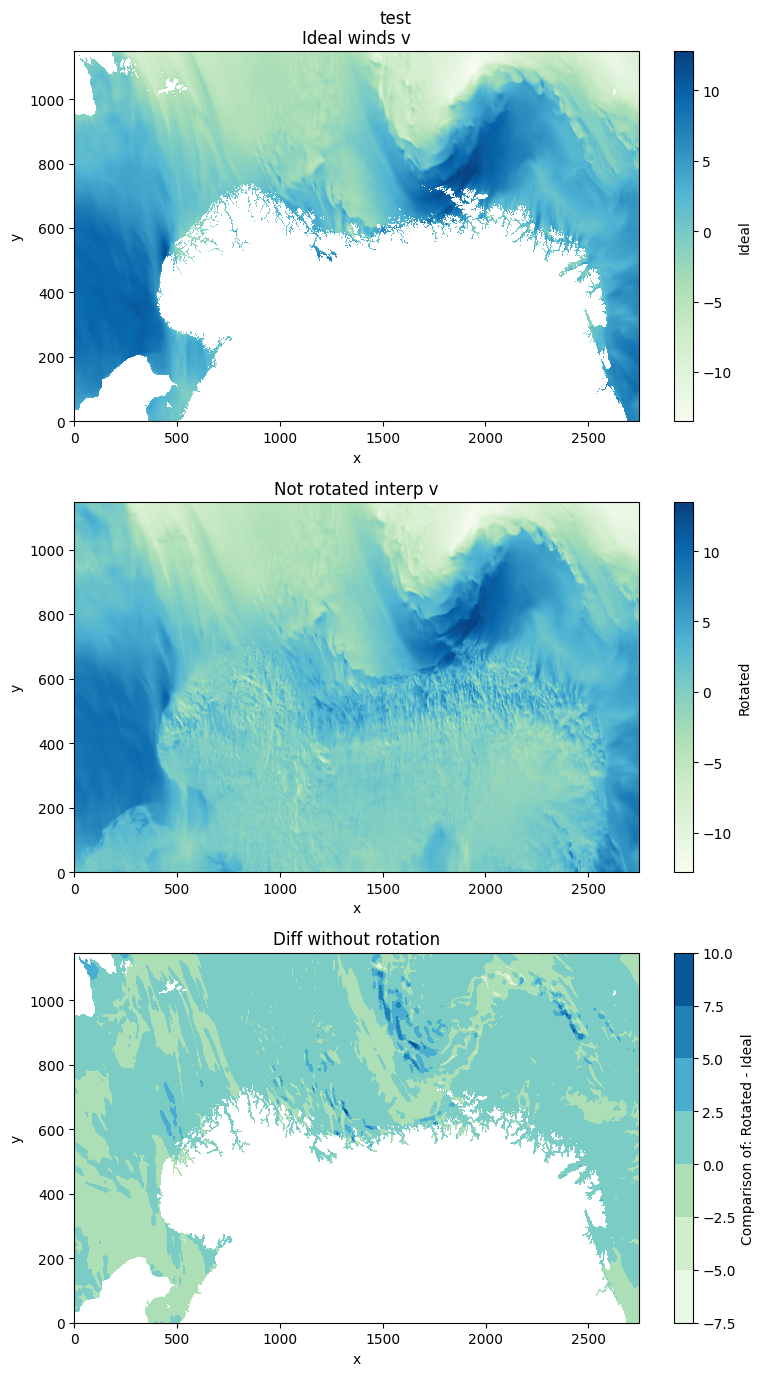

In [44]:
plotting_output_compare(variable_1=ds_ideal_v_2023, variable_2=interp_2023_v["Vwind"], title_1="Ideal winds v", title_2="Not rotated interp v", title_3="Diff without rotation", suptitle="test", variable_1_name="Ideal", variable_2_name="Rotated")


In [45]:
#tester med zarr - dvs anemoi dataset

In [46]:
file_path_zarr = f'/lustre/storeB/project/fou/hi/foccus/datasets/forcing_norkystv3_hindcast_zarr/forcing_norkystv3_hindcast_2023.zarr'

In [47]:
from anemoi.datasets import open_dataset
ds_zarr_forc_u = open_dataset(file_path_zarr, select = "Uwind", start = '2023-05-01T00:00:00', end = '2023-05-01T01:00:00')
ds_zarr_forc_u.shape

Dataset /lustre/storeB/project/fou/hi/foccus/datasets/forcing_norkystv3_hindcast_zarr/forcing_norkystv3_hindcast_2023.zarr has missing dates


(1, 1, 1, 3153556)

In [48]:
ds_ideal_u_2023_1d = ds_ideal_u_2023.values.flatten()
ds_ideal_u_2023_1d.shape

(3153556,)

In [49]:
diff_zarr_ideal = ds_zarr_forc_u - ds_ideal_u_2023_1d
replace_nan = np.where(np.isnan(diff_zarr_ideal), 0, diff_zarr_ideal)
if np.any(replace_nan != 0):
    print("There are differences between the zarr dataset and the ideal dataset.")
else:
    print("The zarr dataset matches the ideal dataset.")

There are differences between the zarr dataset and the ideal dataset.


In [50]:
import cartopy
import cmocean
import cartopy.crs as ccrs


In [86]:
def speed(file_name, variable, year, datetime, time_indx, cbar_title, **kwargs):
    file_name = file_name #the file you wish to use to plot the variables
    ds_file = open_dataset(file_name, select = variable) #open dataset and choose variable from dataset
    fig,ax = plt.subplots(figsize = (8,10), subplot_kw={"projection": ccrs.NorthPolarStereo()})
    im = ax.scatter(ds_file.longitudes, ds_file.latitudes, c = ds_file[time_indx,0,0,:], s=2, cmap = cmocean.cm.speed, **kwargs, transform = ccrs.PlateCarree()) #time_indx is a list of time indexes when calling the function
    #ax.add_feature(cartopy.feature.LAND, zorder = 1, edgecolor = "black") If one wishes to add land features and thus remove values on land
    ax.coastlines()
    cax = fig.add_axes([ax.get_position().x1+0.025, ax.get_position().y0, 0.025, ax.get_position().height])
    cbar = fig.colorbar(im, ax=ax, cax=cax, extend = "both")
    cbar.ax.set_title(cbar_title, fontsize = 14) #cbar_title: the title of the colorbar
    ax.set_title(f'+ {time_indx*3}h from {year} - {datetime}') #year of selected data + time_indx is multiplied with three because of three hour frequency in the interp forcings dataset
    plt.show()

Dataset /lustre/storeB/project/fou/hi/foccus/datasets/forcing_norkystv3_hindcast_zarr/forcing_norkystv3_hindcast_2023.zarr has missing dates


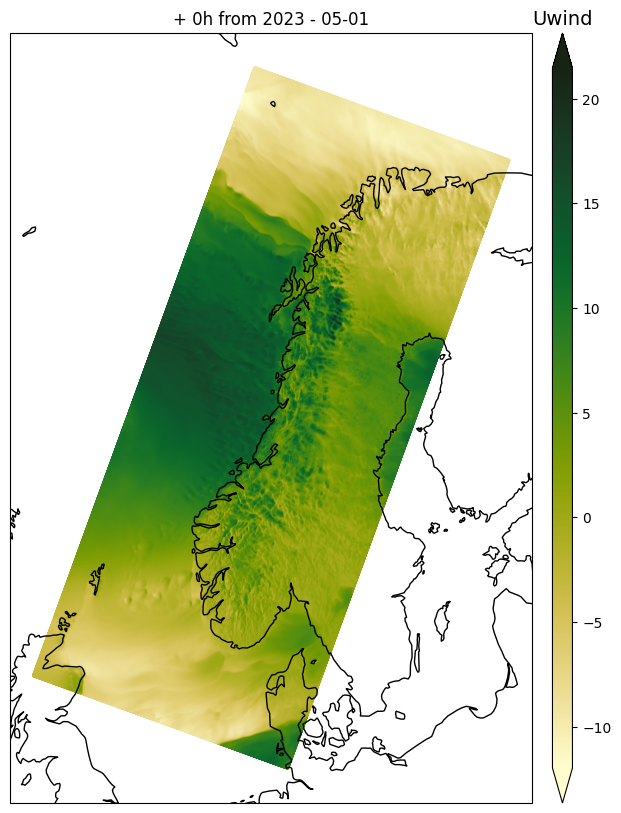

In [87]:
for time_indx in [0]:
    speed('/lustre/storeB/project/fou/hi/foccus/datasets/forcing_norkystv3_hindcast_zarr/forcing_norkystv3_hindcast_2023.zarr', variable="Uwind", year=2023, datetime="05-01", cbar_title="Uwind", time_indx=time_indx)

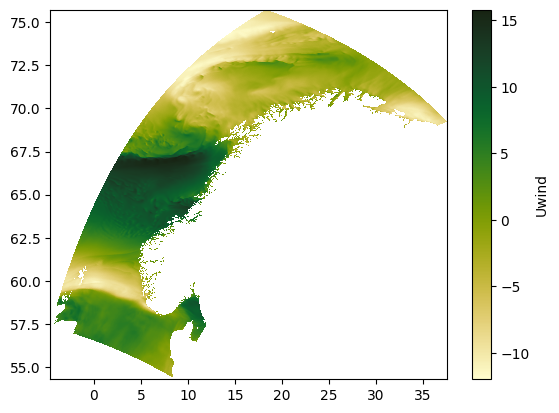

In [90]:
plt.pcolormesh(ds_ideal_u_2023.lon, ds_ideal_u_2023.lat, ds_ideal_u_2023.values, cmap = cmocean.cm.speed)
plt.colorbar(label="Uwind")

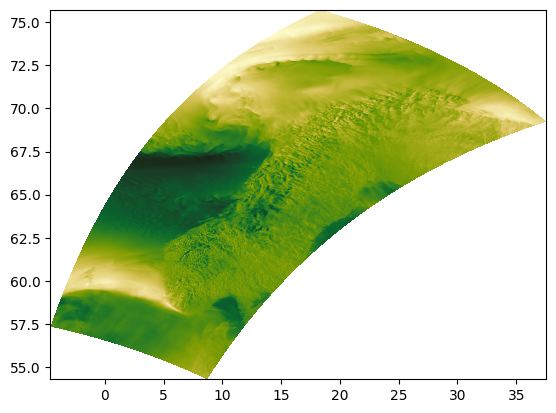

In [91]:
plt.pcolormesh(interp_2023_u["lon"].values, interp_2023_u["lat"].values, interp_2023_u["Uwind"].values, cmap = cmocean.cm.speed)

In [51]:
abs_val_ideal = np.sqrt(ds_ideal_u_2023.values**2 + ds_ideal_v_2023.values**2)
abs_val_interp = np.sqrt(interp_2023_u["Uwind"].values**2 + interp_2023_v["Vwind"].values**2)

/tmp/ipykernel_999602/3726884462.py:22: UserWarning: The following kwargs were not used by contour: 'shading'
  image3 = ax[2].contourf(variable_2 - variable_1, shading = "auto")#, norm = norm2)


<function __main__.plotting_output_compare(variable_1, variable_2, title_1, title_2, title_3, variable_1_name, variable_2_name, suptitle)>

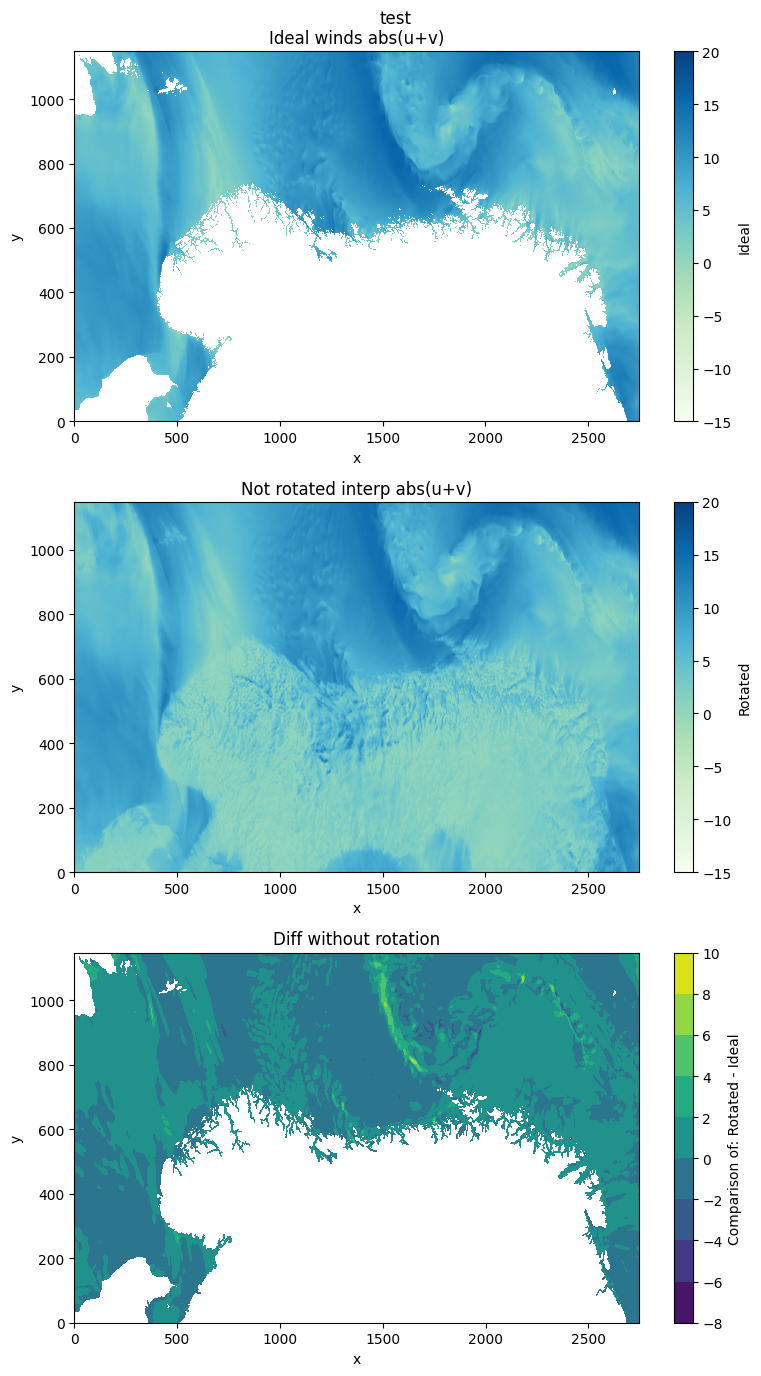

In [59]:
plotting_output_compare(variable_1=abs_val_ideal, variable_2=abs_val_interp, title_1="Ideal winds abs(u+v)", title_2="Not rotated interp abs(u+v)", title_3="Diff without rotation", suptitle="test", variable_1_name="Ideal", variable_2_name="Rotated")


/tmp/ipykernel_999602/3726884462.py:22: UserWarning: The following kwargs were not used by contour: 'shading'
  image3 = ax[2].contourf(variable_2 - variable_1, shading = "auto")#, norm = norm2)


<function __main__.plotting_output_compare(variable_1, variable_2, title_1, title_2, title_3, variable_1_name, variable_2_name, suptitle)>

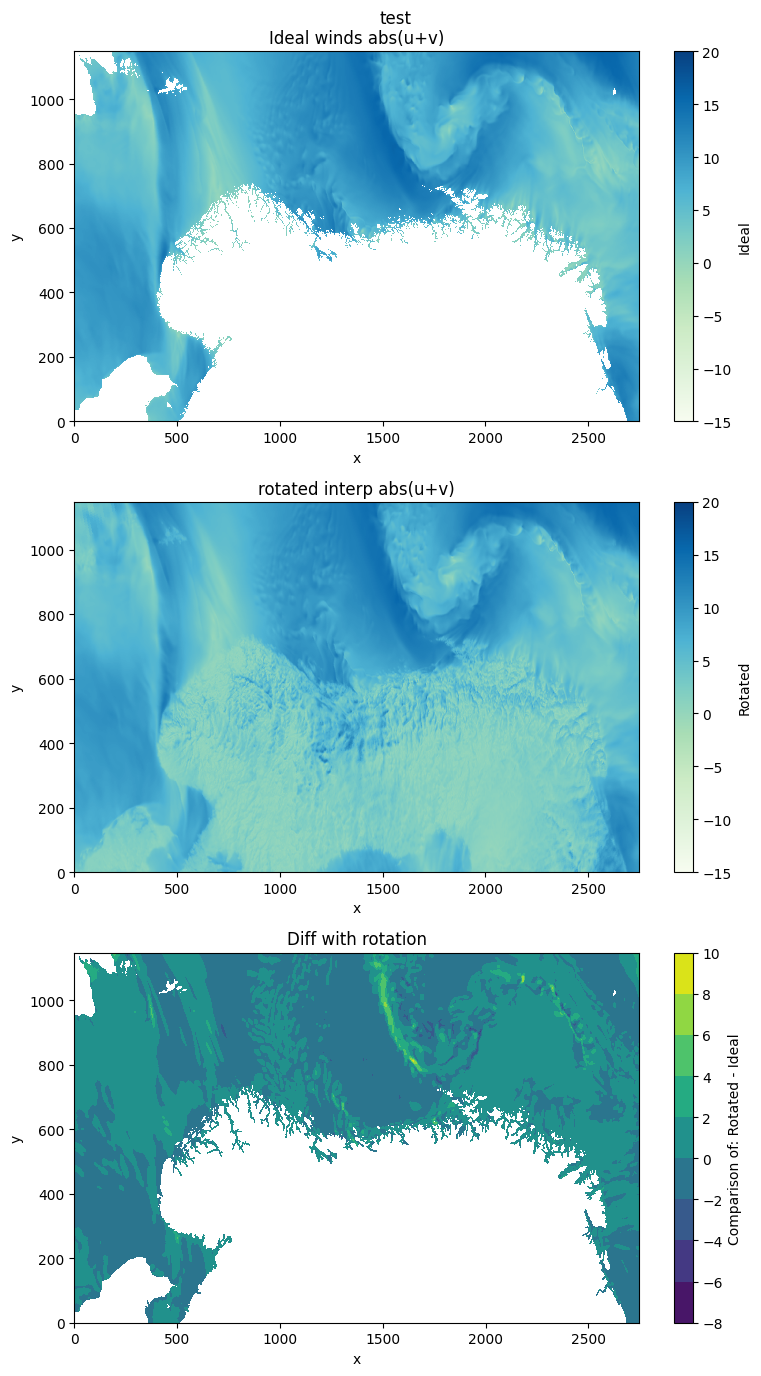

In [60]:
abs_val_rot = np.sqrt(urot**2 + vrot**2)    
plotting_output_compare(variable_1=abs_val_ideal, variable_2=abs_val_rot, title_1="Ideal winds abs(u+v)", title_2="rotated interp abs(u+v)", title_3="Diff with rotation", suptitle="test", variable_1_name="Ideal", variable_2_name="Rotated")


In [12]:
min = interp_2023_u["Uwind"].min().item()
max = interp_2023_u["Uwind"].max().item()
print(f'range [{min}, {max}]')

range [-11.8731059915356, 15.418920731049164]


In [4]:
interp_2023_u.min

<bound method DatasetAggregations.min of <xarray.Dataset> Size: 76MB
Dimensions:           (Y: 1148, X: 2747)
Coordinates:
    time              datetime64[ns] 8B 2023-05-01
  * X                 (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
  * Y                 (Y) float64 9kB 0.0 800.0 1.6e+03 ... 9.168e+05 9.176e+05
    s_rho             float64 8B ...
Data variables:
    lon               (Y, X) float64 25MB ...
    lat               (Y, X) float64 25MB ...
    Uwind             (Y, X) float64 25MB ...
    projection_stere  int32 4B ...>

In [52]:
ds_ideal_2023_u_selarea = ds_ideal_2023["Uwind_eastward"]
ds_ideal_2023_v_selarea = ds_ideal_2023["Vwind_northward"]
lon = ds_ideal_2023_u_selarea["lon"]
lat = ds_ideal_2023_u_selarea["lat"]

In [32]:
"""import cartopy.crs as ccrs
import cartopy
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0, linestyle='--')
ax.quiver(lon, lat, ds_ideal_2023_u_selarea, ds_ideal_2023_v_selarea)"""


"import cartopy.crs as ccrs\nimport cartopy\nfig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})\nax.coastlines()\ngl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\n                  linewidth=1, color='gray', alpha=0, linestyle='--')\nax.quiver(lon, lat, ds_ideal_2023_u_selarea, ds_ideal_2023_v_selarea)"

<bound method Dataset.sel of <xarray.Dataset> Size: 76MB
Dimensions:           (Y: 1148, X: 2747)
Coordinates:
    time              datetime64[ns] 8B 2023-05-01
  * X                 (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
  * Y                 (Y) float64 9kB 0.0 800.0 1.6e+03 ... 9.168e+05 9.176e+05
    s_rho             float64 8B ...
Data variables:
    lon               (Y, X) float64 25MB ...
    lat               (Y, X) float64 25MB ...
    Uwind             (Y, X) float64 25MB ...
    projection_stere  int32 4B ...>

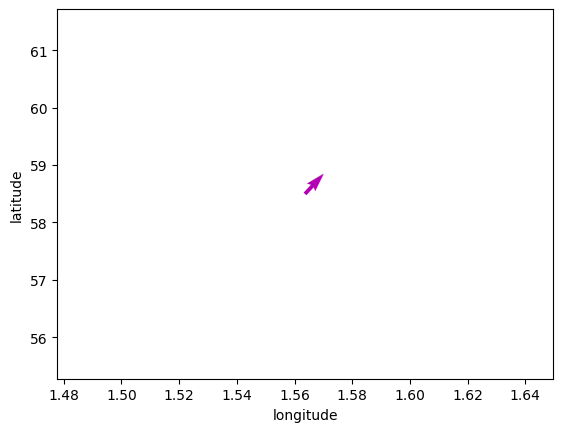

In [53]:
plt.quiver(lon,lat,ds_ideal_2023_u_selarea, ds_ideal_2023_v_selarea, color = "magenta")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.quiver(lon,lat, interp_2023_u["Uwind"], interp_2023_v["Vwind"], color = "black", alpha = 0.3)


In [45]:
ds_ideal_2023_n = xr.open_dataset(f'{ideal_file_path}/2023/05/norkyst800-20230501.nc').isel(time = 0, s_rho = -1, X = 413, Y = 910)
interp_2023_u_n = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Uwind.nc').isel(time=0, X = 413, Y=910)
interp_2023_v_n = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Vwind.nc').isel(time=0, X = 413, Y=910)

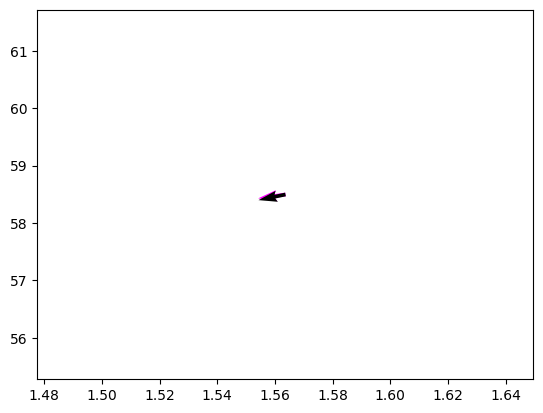

In [47]:
plt.quiver(lon,lat,ds_ideal_2023_n["Uwind_eastward"], ds_ideal_2023_n["Vwind_northward"], color = "magenta")
plt.quiver(lon,lat,interp_2023_u_n["Uwind"],interp_2023_v_n["Vwind"])

In [48]:
ds_ideal_2023_n = xr.open_dataset(f'{ideal_file_path}/2023/05/norkyst800-20230501.nc').isel(time = 0, s_rho = -1, X = 23, Y = 213)
interp_2023_u_n = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Uwind.nc').isel(time=0, X = 23, Y=213)
interp_2023_v_n = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Vwind.nc').isel(time=0, X = 23, Y=213)

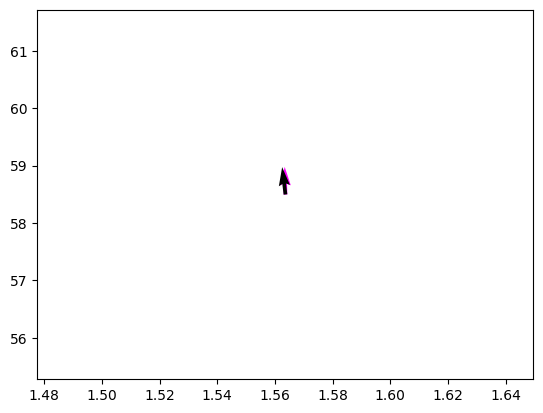

In [49]:
plt.quiver(lon,lat,ds_ideal_2023_n["Uwind_eastward"], ds_ideal_2023_n["Vwind_northward"], color = "magenta")
plt.quiver(lon,lat,interp_2023_u_n["Uwind"],interp_2023_v_n["Vwind"])

In [ ]:
ds_ideal_2023_slice = xr.open_dataset(f'{ideal_file_path}/2023/05/norkyst800-20230501.nc').isel(time = 0, s_rho = -1, X = slice(23,46), Y = slice(45,68))
interp_2023_u_slice = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Uwind.nc').isel(time=0, X = slice(23,46), Y = slice(45,68))
interp_2023_v_slice = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Vwind.nc').isel(time=0, X = slice(23,46), Y = slice(45,68))
#ds_ideal_2023_slice["Uwind_eastward"].values.__len__()
#interp_2023_u_slice["Uwind"].values.__len__()
#interp_2023_v_slice["Vwind"].values.__len__()

print(f'Ideal: Uw: {ds_ideal_2023_slice["Uwind_eastward"].shape}, Vw:{ds_ideal_2023_slice["Vwind_northward"].shape}, X: {ds_ideal_2023_slice.X.shape}, Y: {ds_ideal_2023_slice.Y.shape}')
X,Y = np.meshgrid(ds_ideal_2023_slice.X, ds_ideal_2023_slice.Y)

Ideal: Uw: (23, 23), Vw:(23, 23), X: (23,), Y: (23,)


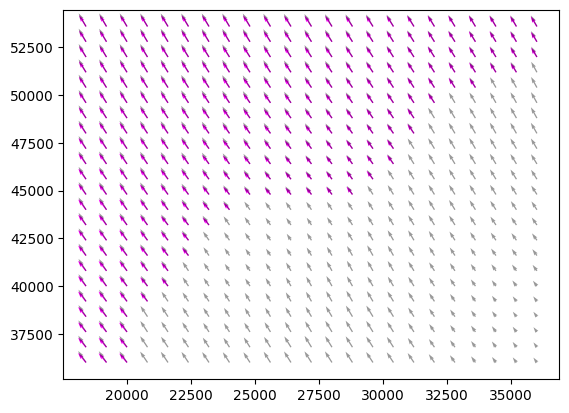

In [86]:
plt.quiver(X,Y,ds_ideal_2023_slice["Uwind_eastward"], ds_ideal_2023_slice["Vwind_northward"], color = "magenta")
plt.quiver(X,Y,interp_2023_u_slice["Uwind"], interp_2023_v_slice["Vwind"], color = "black", alpha = 0.4)

In [87]:

ds_ideal_2023_slice = xr.open_dataset(f'{ideal_file_path}/2023/05/norkyst800-20230501.nc').isel(time = 0, s_rho = -1, X = slice(213,243), Y = slice(527,557))
interp_2023_u_slice = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Uwind.nc').isel(time=0, X = slice(213,243), Y = slice(527,557))
interp_2023_v_slice = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Vwind.nc').isel(time=0, X = slice(213,243), Y = slice(527,557))
#ds_ideal_2023_slice["Uwind_eastward"].values.__len__()
#interp_2023_u_slice["Uwind"].values.__len__()
#interp_2023_v_slice["Vwind"].values.__len__()

print(f'Ideal: Uw: {ds_ideal_2023_slice["Uwind_eastward"].shape}, Vw:{ds_ideal_2023_slice["Vwind_northward"].shape}, X: {ds_ideal_2023_slice.X.shape}, Y: {ds_ideal_2023_slice.Y.shape}')
X,Y = np.meshgrid(ds_ideal_2023_slice.X, ds_ideal_2023_slice.Y)

Ideal: Uw: (30, 30), Vw:(30, 30), X: (30,), Y: (30,)


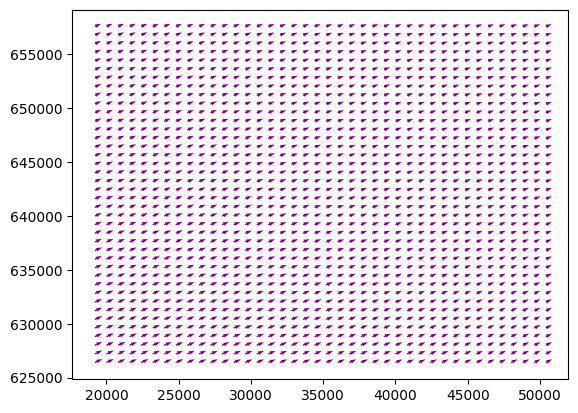

In [ ]:
plt.quiver(X,Y,ds_ideal_2023_slice["Uwind_eastward"], ds_ideal_2023_slice["Vwind_northward"], color = "magenta")
plt.quiver(X,Y,interp_2023_u_slice["Uwind"], interp_2023_v_slice["Vwind"], color = "black", alpha = 0.5)

In [89]:

ds_ideal_2023_slice = xr.open_dataset(f'{ideal_file_path}/2023/05/norkyst800-20230501.nc').isel(time = 0, s_rho = -1, X = slice(24,64), Y = slice(783,823))
interp_2023_u_slice = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Uwind.nc').isel(time=0, X = slice(24,64), Y = slice(783,823))
interp_2023_v_slice = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Vwind.nc').isel(time=0, X = slice(24,64), Y = slice(783,823))
#ds_ideal_2023_slice["Uwind_eastward"].values.__len__()
#interp_2023_u_slice["Uwind"].values.__len__()
#interp_2023_v_slice["Vwind"].values.__len__()

print(f'Ideal: Uw: {ds_ideal_2023_slice["Uwind_eastward"].shape}, Vw:{ds_ideal_2023_slice["Vwind_northward"].shape}, X: {ds_ideal_2023_slice.X.shape}, Y: {ds_ideal_2023_slice.Y.shape}')
X,Y = np.meshgrid(ds_ideal_2023_slice.X, ds_ideal_2023_slice.Y)

Ideal: Uw: (40, 40), Vw:(40, 40), X: (40,), Y: (40,)


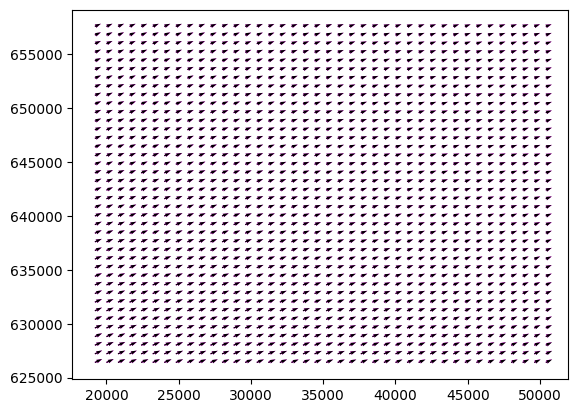

In [91]:
plt.quiver(X,Y,ds_ideal_2023_slice["Uwind_eastward"], ds_ideal_2023_slice["Vwind_northward"], color = "magenta")
plt.quiver(X,Y,interp_2023_u_slice["Uwind"], interp_2023_v_slice["Vwind"], color = "black")


Text(0.5, 1.0, 'abs interp - abs ideal')

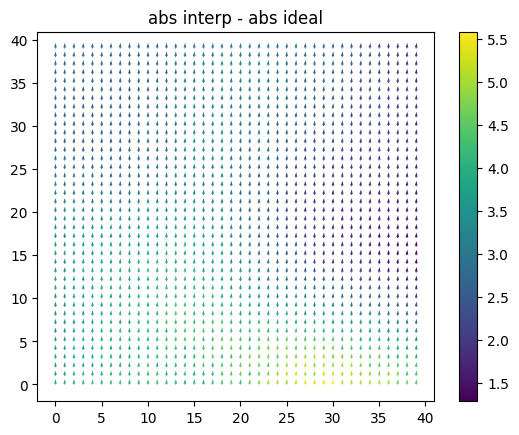

In [103]:
abs_id = (ds_ideal_2023_slice["Uwind_eastward"]**2 + ds_ideal_2023_slice["Vwind_northward"]**2)
abs_int = (interp_2023_u_slice["Uwind"]**2 + interp_2023_v_slice["Vwind"]**2)
plt.quiver(X,Y,abs_int - abs_id)
plt.colorbar()
plt.title(f'abs interp - abs ideal')